In [1]:
import os

os.environ["QUIMB_NUM_THREAD_WORKERS"] = "1"

In [2]:
import sys

sys.path.append("../../src")

In [3]:
import matplotlib.pylab as plt
import matplotlib.font_manager as fm


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 9, 6
import copy
plt.rcParams.update({'font.size': 20})

In [4]:
import quimb as qu
import quimb.tensor as qtn

In [5]:
from qiskit import Aer
from qiskit.quantum_info.operators.operator import Operator
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, transpile

In [6]:
from optimize import TNOptimizer
from fit_functions import compute_likelihood, causality_keys_to_op_arrays

In [7]:
import seaborn as sns

sns.set_style("whitegrid")

In [8]:
import scipy

In [9]:
import jax.numpy as jnp
import numpy as np

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
from utilities import *
from preprocess import (
    shadow_results_to_data_vec,
    shadow_seqs_to_op_array_rz,
    shadow_seqs_to_op_array,
    pure_measurement,
    clifford_rz_unitaries_vT,
    clifford_measurements_vT,
    clifford_unitaries_vT,
    val_rz_unitaries_vT,
    val_unitaries_vT,
    val_measurements_vT,
)
from preprocess import clifford_param_dict, validation_param_dict

In [12]:
from process_tensor_networks import (
    create_PT_PEPO_guess,
    expand_initial_guess_,
    create_PEPO_X_decomp,
)

In [13]:
from fit_functions import compute_probabilities

In [14]:
simulator = Aer.get_backend("aer_simulator_density_matrix")

In [15]:
NSTEPS = 5
nQ = 1
basis_gates = ["cx", "rz", "sx", "x", "unitary"]

In [16]:
def create_env_IA(rxx, ryy, rzz):
    U = scipy.linalg.expm(
        -1.0j * 0.5 * (rxx * np.kron(X, X) + ryy * np.kron(Y, Y) + rzz * np.kron(Z, Z))
    )

    U = Operator(U, 4, 4)
    return U

In [17]:
def spillage_rot(circ, rot, target_qubit, init_qubits):
    n_2 = int(len(init_qubits))
    circ.barrier()

    for i in range(n_2):
        circ.crx(rot, target_qubit, init_qubits[i])

    circ.barrier()
    return None

In [18]:
def append_PT_gates(circ, env_IA, rot, init_qubits, crosstalk_IA=None):

    param_dict = {
        (q, t): [
            Parameter(f"t{t}_q{q}_x"),
            Parameter(f"t{t}_q{q}_y"),
            Parameter(f"t{t}_q{q}_z"),
        ]
        for q in range(nQ)
        for t in range(NSTEPS + 1)
    }

    # can modify circuit structure here if desired

    for i in range(NSTEPS):
        for j in range(nQ):

            circ.rz(param_dict[(j, i)][2], j + 1)

            circ.sx(j + 1)
            spillage_rot(circ, rot, j + 1, init_qubits)

            circ.rz(param_dict[(j, i)][0] + np.pi, j + 1)

            circ.sx(j + 1)
            spillage_rot(circ, rot, j + 1, init_qubits)

            circ.rz(param_dict[(j, i)][1] + 3 * np.pi, j + 1)

        #            circ.u3(*param_dict[(j,i)], j+1)
        for j in range(nQ):
            circ.append(env_IA, [0, j + 1])
            if crosstalk_IA is not None and j < nQ - 1:
                circ.append(crosstalk_IA, [j + 1, j + 2])

    for j in range(nQ):
        circ.rz(param_dict[(j, NSTEPS)][2], j + 1)

        circ.sx(j + 1)
        spillage_rot(circ, rot, j + 1, init_qubits)

        circ.rz(param_dict[(j, NSTEPS)][0] + np.pi, j + 1)

        circ.sx(j + 1)
        spillage_rot(circ, rot, j + 1, init_qubits)

        circ.rz(param_dict[(j, NSTEPS)][1] + 3 * np.pi, j + 1)

    for j in range(nQ):
        circ.measure(j + 1, j)

    return None

In [19]:
def base_PT_circ_template(env_IA, init_qubits, corr_rot, crosstalk_IA=None):

    qreg_size = nQ + 1  # + len(init_qubits)

    circ = QuantumCircuit(qreg_size, nQ)
    circ.ry(np.pi / 4, 0)
    # Insert fancy circuit here

    append_PT_gates(
        circ, env_IA, corr_rot, init_qubits, crosstalk_IA=crosstalk_IA
    )  # for insertion of DD sequence

    # Insert fancy circuit here

    return transpile(circ, basis_gates=basis_gates, optimization_level=1)

In [20]:
def shadow_PT_circs(no_shadows, template):

    shadow_circs = []
    shadow_sequences = []
    for i in range(no_shadows):
        clifford_seq = list(np.random.randint(0, 24, (NSTEPS + 1, nQ)))
        circ_params = np.array(
            [clifford_param_dict[N] for param_set in clifford_seq for N in param_set]
        )

        shadow_circs.append(template.bind_parameters(circ_params.flatten()))
        shadow_sequences.append(np.array(clifford_seq).T)
    return shadow_circs, shadow_sequences


def validation_PT_circs(no_shadows, template):

    shadow_circs = []
    shadow_sequences = []
    for i in range(no_shadows):
        val_seq = list(np.random.randint(0, 100, (NSTEPS + 1, nQ)))
        circ_params = np.array(
            [validation_param_dict[N] for param_set in val_seq for N in param_set]
        )

        shadow_circs.append(template.bind_parameters(circ_params.flatten()))
        shadow_sequences.append(np.array(val_seq).T)
    return shadow_circs, shadow_sequences

In [21]:
env_IA = create_env_IA(np.pi / 15, np.pi / 15, np.pi / 10)
crosstalk_IA = None

dist_size = 1
cor_size = np.pi / 8


template_args = {
    "env_IA": env_IA,
    #'init_qubits' : [i for i in range(nQ + 1, nQ + 1 + dist_size)],
    "init_qubits": [0],
    "corr_rot": cor_size,
    "crosstalk_IA": crosstalk_IA,
}

PT_template_t = base_PT_circ_template(**template_args)
PT_template_t.global_phase = 0

/Users/gregorywhite/.pyenv/versions/3.9/envs/qiskit-PTNs/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [22]:
PT_template_t.draw(fold=-1)

┌────────┐  ┌────┐┌──────────┐┌────┐ ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                           ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                     ┌──────────┐                      ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                           ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                     ┌──────────┐                      ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                           ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                     ┌──────────┐                      ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                           ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                     ┌──────────┐                      ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                           ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                     ┌──────────┐                      ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                           ░ ┌─────────┐┌────┐┌───────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌────┐┌─────────┐ ░                        
q_0: ───┤ Rz(-π) ├──┤ √X ├┤ Rz(3π/4) ├┤ √X ├─░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────────────┤0         ├──────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────────────┤0         ├──────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────────────┤0         ├──────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────────────┤0         ├──────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░─────────────────────┤0         ├──────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░───────────────────────────░─┤ Rz(π/2) ├┤ √X ├┤ Rz(9π/16) ├┤ X ├┤ Rz(-π/16) ├┤ X ├┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─░────────────────────────
     ┌──┴────────┴─┐├────┤└──────────┘└────┘ ░ └─────────┘└────┘└───────────┘└─┬─┘└───────────┘└─┬─┘└─────────┘└────┘└─────────┘ ░ ┌─────────────────┐┌────┐ ░ └─────────┘└────┘└───────────┘└─┬─┘└───────────┘└─┬─┘└─────────┘└────┘└─────────┘ ░ ┌──────────────────┐│  Unitary │┌─────────────┐┌────┐ ░ └─────────┘└────┘└───────────┘└─┬─┘└───────────┘└─┬─┘└─────────┘└────┘└─────────┘ ░ ┌─────────────────┐┌────┐ ░ └─────────┘└────┘└───────────┘└─┬─┘└───────────┘└─┬─┘└─────────┘└────┘└─────────┘ ░ ┌──────────────────┐│  Unitary │┌─────────────┐┌────┐ ░ └─────────┘└────┘└───────────┘└─┬─┘└───────────┘└─┬─┘└─────────┘└────┘└─────────┘ ░ ┌─────────────────┐┌────┐ ░ └─────────┘└────┘└───────────┘└─┬─┘└───────────┘└─┬─┘└─────────┘└────┘└─────────┘ ░ ┌──────────────────┐│  Unitary │┌─────────────┐┌────┐ ░ └─────────┘└────┘└───────────┘└─┬─┘└───────────┘└─┬─┘└─────────┘└────┘└─────────┘ ░ ┌─────────────────┐┌────┐ ░ └─────────┘└────┘└───────────┘└─┬─┘└───

In [23]:
val_circs, val_sequences = validation_PT_circs(300, PT_template_t)

/var/folders/tc/wj5dym79723gmnk9qgkhg13w0000gn/T/ipykernel_72648/766716754.py:26: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  shadow_circs.append(template.bind_parameters(circ_params.flatten()))


In [24]:
val_shots = 16384
val_job = simulator.run(val_circs, shots=val_shots)

In [25]:
val_dict = {"res": val_job.result().get_counts(), "seqs": val_sequences}

In [26]:
val_shadow_sequences = val_dict["seqs"]
val_data, val_keys = shadow_results_to_data_vec(val_dict["res"], shots=val_shots, nQ=nQ)

In [27]:
v_data_entropy = (
    -(1 / len(val_data)) * jnp.array(val_data) @ jnp.log(jnp.array(val_data))
)
print(v_data_entropy)

0.27382135


In [28]:
no_jobs = 20
circ_shots = 1024

In [29]:
job_dict = {}
counter = 0

In [30]:
for i in range(no_jobs):
    tmp_circs, tmp_sequences = shadow_PT_circs(300, PT_template_t)
    tmp_job = simulator.run(tmp_circs, shots=circ_shots)
    tmp_dict = {"res": tmp_job.result().get_counts(), "seqs": tmp_sequences}
    job_dict[i] = tmp_dict
    counter += 1

/var/folders/tc/wj5dym79723gmnk9qgkhg13w0000gn/T/ipykernel_72648/766716754.py:11: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  shadow_circs.append(template.bind_parameters(circ_params.flatten()))


In [31]:
shadow_sequences = []
for J in job_dict.items():
    shadow_sequences += J[1]["seqs"]

In [32]:
training_data = []
for i in range(len(job_dict)):
    training_data += job_dict[i]["res"]

In [33]:
training_data_flat, training_keys = shadow_results_to_data_vec(
    training_data, circ_shots, nQ
)
val_shadow_sequences = val_dict["seqs"]

In [34]:
new_shadow_sequences = []
for seq in shadow_sequences:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_shadow_sequences.append(tmp)

In [35]:
new_val_sequences = []
for seq in val_shadow_sequences:
    tmp = []
    for T in seq:
        tmp.append([O for O in reversed(T)])
    tmp.reverse()
    new_val_sequences.append(tmp)

In [36]:
training_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_shadow_sequences, training_keys, pure_measurement, clifford_rz_unitaries_vT
)

In [37]:
val_sequences_v_rz = shadow_seqs_to_op_array_rz(
    new_val_sequences, val_keys, pure_measurement, val_rz_unitaries_vT
)

In [38]:
training_sequences_v = shadow_seqs_to_op_array(
    new_shadow_sequences, training_keys, clifford_measurements_vT, clifford_unitaries_vT
)

In [39]:
val_sequences_v = shadow_seqs_to_op_array(
    new_val_sequences, val_keys, val_measurements_vT, val_unitaries_vT
)

In [40]:
nS = NSTEPS

no_epochs = 600
batch_size = 1000
K_lists = [[1] + [1 for j in range(nS - 1)] + [1] for i in range(nQ)]
vertical_bonds = [[1] + [1 for i in range(nQ - 3)] + [1] for j in range(nS)] + [
    [1 for i in range(nQ - 1)]
]
horizontal_bonds = [1 for i in range(nS)]
initial_guess = create_PT_PEPO_guess(nS, nQ, horizontal_bonds, vertical_bonds, K_lists)

In [41]:
real_K_lists = [[2] + [1 for j in range(nS - 1)] + [2] for i in range(nQ)]
real_vertical_bonds = [[2 for i in range(nQ - 1)]] + [
    [2] + [2 for i in range(nQ - 3)] + [2] for j in range(nS)
]
real_horizontal_bonds = [[1 for i in range(nS + 1)] for i in range(nQ)]
expand_initial_guess_(
    initial_guess,
    real_K_lists,
    real_horizontal_bonds,
    real_vertical_bonds,
    rand_strength=0.05,
    squeeze=True,
)
Lx = initial_guess.Lx
Ly = initial_guess.Ly

In [43]:
new_X_guess = create_PEPO_X_decomp(nS, nQ, rand_strength=0.0)

In [44]:
for i in range(2 * (NSTEPS + 1)):
    if i == 0:
        new_X_guess.tensors[i].new_ind(f"left_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"left_bond_{i}", 4)

    elif i == 2 * (NSTEPS + 1) - 1:
        new_X_guess.tensors[i].new_ind(f"right_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"right_bond_{i}", 4)
    else:
        new_X_guess.tensors[i].new_ind(f"left_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"left_bond_{i}", 4)
        new_X_guess.tensors[i].new_ind(f"right_bond_{i}")
        new_X_guess.tensors[i].expand_ind(f"right_bond_{i}", 4)

In [45]:
for i in range(2 * (NSTEPS + 1) - 1):
    if i == 0:
        qtn.tensor_core.connect(
            new_X_guess.tensors[i], new_X_guess.tensors[i + 1], 0, 0
        )
    if i > 0:
        qtn.tensor_core.connect(
            new_X_guess.tensors[i], new_X_guess.tensors[i + 1], 1, 0
        )

In [47]:
rand_strength = 0.01

for i in range(2 * (NSTEPS + 1)):
    tmp_D = new_X_guess.tensors[i].data
    new_X_guess.tensors[i].modify(
        data=tmp_D
        + rand_strength * np.random.rand(*tmp_D.shape)
        + rand_strength * 1.0j * np.random.rand(*tmp_D.shape)
    )

In [48]:
data_entropy = (
    -(1 / len(training_data_flat))
    * np.array(training_data_flat)
    @ np.log(np.array(training_data_flat))
)
v_data_entropy = -(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(val_data))
print(data_entropy)
print(v_data_entropy)

0.2856347286095997
0.27382146059479273


In [49]:
iterations = int(3 * no_epochs * len(training_data_flat) / batch_size)

In [50]:
instructions = {
    "normal": {
        "initial_tn": initial_guess,
        "training_seqs": training_sequences_v,
        "val_seqs": val_sequences_v,
        "likelihood_const": False,
    },
    "X_decomp": {
        "initial_tn": initial_guess & new_X_guess,
        "training_seqs": training_sequences_v_rz,
        "val_seqs": val_sequences_v_rz,
        "likelihood_const": True,
    },
}

In [51]:
mode = "X_decomp"

In [52]:
# Self-consistent PTT with correlated control bonds
corr_Xoptmzr = TNOptimizer(
    initial_guess & new_X_guess,  # our initial input, the tensors of which to optimize
    loss_fn=compute_likelihood,
    causality_fn=causality_keys_to_op_arrays,
    causality_key_size=200,
    training_data=jnp.array(training_data_flat),
    training_sequences=instructions[mode]["training_seqs"],
    Lx=Lx,
    Ly=Ly,
    validation_data=list(val_data),
    validation_sequences=instructions[mode]["val_seqs"],
    batch_size=batch_size,
    loss_constants={},  # this is a constant TN to supply to loss_fn
    loss_kwargs={
        "kappa": 1,
        "opt": "auto-hq",
        "X_decomp": instructions[mode]["likelihood_const"],
    },
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="adam",  # supplied to scipy.minimize
    progbar=True,
)

In [53]:
corr_X_pepo_opt = corr_Xoptmzr.optimize(
    2 * iterations
)  # modelling spillage; can stop whenever it seems convergence with respect to the validation

+0.2869137 [best loss: +0.2755891] [best val: +0.2739033; (13668)]:  21%|██▏       | 13794/64800 [22:10<1:21:58, 10.37it/s]


In [54]:
corr_Xoptmzr.val_best - v_data_entropy

8.181990180455845e-05

In [55]:
best_val_mpo = corr_Xoptmzr.best_val_mpo

In [56]:
v_predictions = compute_probabilities(
    best_val_mpo,
    instructions[mode]["val_seqs"],
    X_decomp=instructions[mode]["likelihood_const"],
    opt="auto-hq",
)
v_predictions = sum(val_data) * v_predictions / sum(v_predictions)
print(-(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(v_predictions)))

0.2739031952582399


In [57]:
v_predictions_norm = []
for i in range((2**nQ) * 300):
    tmp_v = v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = tmp_v / sum(tmp_v)
    for v in tmp_v:
        v_predictions_norm.append(v)
v_predictions_norm = np.array(v_predictions_norm)

In [58]:
from scipy.stats import describe

In [59]:
describe(np.abs(np.array(val_data) - v_predictions_norm))

DescribeResult(nobs=600, minmax=(6.854534149169922e-05, 0.020627737045288086), mean=0.00526623942113171, variance=1.5170694981369593e-05, skewness=1.0125892244622683, kurtosis=0.9491875533697436)

In [60]:
v_fidelities = []
for i in range(300):
    tmp_v = v_predictions[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = np.array(tmp_v / sum(tmp_v))

    actual_v = np.array(val_data[(2**nQ) * i : (2**nQ) * (i + 1)])
    v_fidelities.append(hellinger_fidelity(tmp_v, actual_v))

In [61]:
describe(v_fidelities)

DescribeResult(nobs=300, minmax=(0.9995569250136005, 1.0000000520055885), mean=0.9999389164605975, variance=6.091683664618314e-09, skewness=-2.012084080344402, kurtosis=4.502358742179195)

In [62]:
no_batches = corr_Xoptmzr._nBatches
epoch_losses = [
    corr_Xoptmzr.losses[no_batches - 1 + no_batches * i]
    for i in range(int(corr_Xoptmzr._n / no_batches))
]
epoch_val_losses = [
    corr_Xoptmzr.val_losses[no_batches - 1 + no_batches * i]
    for i in range(int(corr_Xoptmzr._n / no_batches))
]

In [66]:
mode = "normal"

In [67]:
# Regular PTT
Uoptmzr = TNOptimizer(
    initial_guess,  # our initial input, the tensors of which to optimize
    loss_fn=compute_likelihood,
    causality_fn=causality_keys_to_op_arrays,
    causality_key_size=200,
    training_data=np.array(training_data_flat),
    training_sequences=instructions[mode]["training_seqs"],
    Lx=Lx,
    Ly=Ly,
    validation_data=list(val_data),
    validation_sequences=instructions[mode]["val_seqs"],
    batch_size=batch_size,
    loss_constants={},  # this is a constant TN to supply to loss_fn
    loss_kwargs={
        "kappa": 1,
        "opt": "auto-hq",
        "X_decomp": instructions[mode]["likelihood_const"],
    },
    autodiff_backend="jax",  # {'jax', 'tensorflow', 'autograd'}
    optimizer="adam",  # supplied to scipy.minimize
    progbar=True,
)

In [68]:
U_pepo_opt = Uoptmzr.optimize(iterations)

  0%|          | 0/21600 [00:00<?, ?it/s]

+0.3046963 [best loss: +0.2912021] [best val: +0.2910559; (17153)]: : 21601it [08:18, 43.38it/s]                         


In [74]:
best_val_mpo_U = Uoptmzr.best_val_mpo

In [75]:
v_predictions_2 = compute_probabilities(
    best_val_mpo_U,
    instructions[mode]["val_seqs"],
    X_decomp=instructions[mode]["likelihood_const"],
    opt="auto-hq",
)
v_predictions_2 = sum(val_data) * v_predictions_2 / sum(v_predictions_2)
print(-(1 / len(val_data)) * np.array(val_data) @ np.log(np.array(v_predictions_2)))

0.29102590019986174


In [76]:
v_fidelities_U = []
for i in range(300):
    tmp_v = v_predictions_2[(2**nQ) * i : (2**nQ) * (i + 1)]
    tmp_v = np.array(tmp_v / sum(tmp_v))

    actual_v = np.array(val_data[(2**nQ) * i : (2**nQ) * (i + 1)])
    v_fidelities_U.append(hellinger_fidelity(tmp_v, actual_v))

In [77]:
no_batches_U = Uoptmzr._nBatches
epoch_losses_U = [
    Uoptmzr.losses[no_batches - 1 + no_batches * i]
    for i in range(int(Uoptmzr._n / no_batches))
]
epoch_val_losses_U = [
    Uoptmzr.val_losses[no_batches_U - 1 + no_batches * i]
    for i in range(int(Uoptmzr._n / no_batches))
]

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `~matplotlib.transforms.BboxBase` or None
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  figure: `~matplotlib.figure.Figure`
  fontfamily or family or fontname: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-e

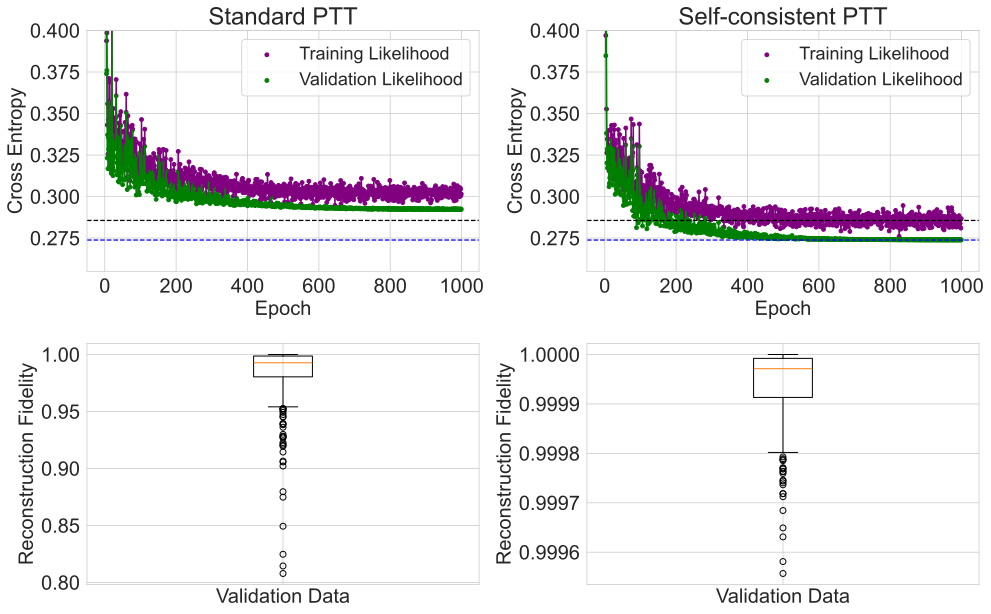

In [78]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

plot_upto = 1000

ax[0, 1].plot(epoch_losses[0:plot_upto], color="purple")
ax[0, 1].plot(epoch_val_losses[0:plot_upto], color="green")
ax[0, 1].scatter(
    range(len(epoch_losses[0:plot_upto])),
    epoch_losses[0:plot_upto],
    s=15,
    color="purple",
    label="Training Likelihood",
)
ax[0, 1].scatter(
    range(len(epoch_val_losses[0:plot_upto])),
    epoch_val_losses[0:plot_upto],
    s=15,
    color="green",
    label="Validation Likelihood",
)
ax[0, 1].axhline(data_entropy, color="black", linestyle="--", linewidth=1.25)
ax[0, 1].axhline(v_data_entropy, color="blue", linestyle="--", linewidth=1.25)
ax[0, 1].set_title("Self-consistent PTT", fontsize=24)
ax[0, 1].set_ylabel("Cross Entropy")
ax[0, 1].set_ylim(0.255, 0.4)
ax[0, 1].set_xlabel("Epoch")
ax[0, 1].legend(fontsize=18)

xticks = ax[0, 1].get_xticklabels()
yticks = ax[0, 1].get_yticklabels()
plt.setp(xticks)
plt.setp(yticks)


ax[0, 0].plot(epoch_losses_U[0:plot_upto], color="purple")
ax[0, 0].plot(epoch_val_losses_U[0:plot_upto], color="green")
ax[0, 0].scatter(
    range(len(epoch_losses_U[0:plot_upto])),
    epoch_losses_U[0:plot_upto],
    s=15,
    color="purple",
    label="Training Likelihood",
)
ax[0, 0].scatter(
    range(len(epoch_val_losses_U[0:plot_upto])),
    epoch_val_losses_U[0:plot_upto],
    s=15,
    color="green",
    label="Validation Likelihood",
)
ax[0, 0].axhline(data_entropy, color="black", linestyle="--", linewidth=1.25)
ax[0, 0].axhline(v_data_entropy, color="blue", linestyle="--", linewidth=1.25)
ax[0, 0].set_title("Standard PTT", fontsize=24)
ax[0, 0].set_ylabel("Cross Entropy")
ax[0, 0].set_ylim(0.255, 0.4)
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].legend(fontsize=18)

xticks = ax[0, 0].get_xticklabels()
yticks = ax[0, 0].get_yticklabels()
plt.setp(xticks)
plt.setp(yticks)

# Bottom left: Box plot for v_fidelities_U
plt.subplot(2, 2, 3)
plt.boxplot(np.array(v_fidelities_U))
plt.ylabel("Reconstruction Fidelity")
plt.xlabel("Validation Data")

xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
plt.setp(xticks, visible=False)
plt.setp(yticks)


# Bottom right: Box plot for v_fidelities
# plt.subplot(2,2,4, sharey=plt.gca())
plt.subplot(2, 2, 4)
# plt.yscale('log')
plt.boxplot(np.array(v_fidelities))
xticks = plt.gca().get_xticklabels()
yticks = plt.gca().get_yticklabels()
plt.setp(xticks, visible=False)
plt.setp(yticks)
plt.ylabel("Reconstruction Fidelity")
plt.xlabel("Validation Data")

plt.subplots_adjust(hspace=0.3, wspace=0.275)

# plt.savefig('Spillage_Benchmark.pdf', bbox_inches = 'tight')
plt.show()